In [1]:
from pathlib import Path

import os
import sys

current_path = Path(os.getcwd())
sys.path.append(str(current_path))

In [2]:
import vectorian
vectorian.compile()

Matching checksum for /Users/arbeit/Projects/vectorian-2021/vectorian/core/cpp/core.cpp --> not compiling


In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [4]:
import vectorian
from vectorian.embeddings import FastText

fasttext = FastText("en")

In [5]:
import vectorian.utils as utils

token_mappings = {
    "tokenizer": [],
    "tagger": []
}

token_mappings["tokenizer"].append(utils.lowercase())
token_mappings["tokenizer"].append(utils.erase("W"))
token_mappings["tokenizer"].append(utils.alpha())

def filter_punct(t):
    return None if t["pos"] == "PUNCT" else t

token_mappings["tagger"].append(filter_punct)
token_mappings["tagger"].append(utils.rewrite({
    'pos': {
        'PROPN': 'NOUN'
    },
    'tag': {
        'NNP': 'NN',
        'NNPS': 'NNS',
    }
}))



In [6]:
from vectorian.importers import StringImporter
from vectorian.session import LabSession

im = StringImporter(nlp)
doc = im("Hey, ye want to talk like a pirate, eh?")


session = LabSession(
    [doc],
    static_embeddings=[fasttext],
    token_mappings=token_mappings)

index = session.index_for_metric("auto", nlp)

Importing <string>: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s]


In [7]:
r = index.find("speak", n=1)
r

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [8]:
session.get_embedding_instance(fasttext).tok2vec("talk").shape

(300,)

In [12]:
import numpy as np
tok2vec = session.get_embedding_instance(fasttext).tok2vec
np.dot(tok2vec("talk"), tok2vec("speak"))

0.60145444

In [8]:
from vectorian.importers import NovelImporter
from vectorian.session import LabSession

im = NovelImporter(nlp)
doc = im("/Users/arbeit/Wise Children.txt")

session = LabSession(
    [doc],
    [fasttext],
    token_mappings)

index = session.index_for_metric("auto", nlp)

Importing /Users/arbeit/Wise Children.txt: 100%|██████████| 369/369 [00:04<00:00, 76.24it/s] 


In [9]:
r = index.find("write female", n=3)  # options={'pos_filter': ["NOUN"]}

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [10]:
r.duration

0.05346989631652832

In [11]:
r

In [16]:
r.annotate()

TypeError: __init__() missing 1 required positional argument: 'location_formatter'

In [13]:
index.find("write female", n=3, on="token", window=(15, 1))

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [15]:
from vectorian.metrics import CosineMetric, WordSimilarityMetric, AlignmentSentenceMetric
from vectorian.alignment import WordMoversDistance

index = session.index_for_metric(AlignmentSentenceMetric(
    word_metric=WordSimilarityMetric(fasttext, CosineMetric()),
    alignment=WordMoversDistance()))

query = nlp("the great star")
#query = nlp("making america great again")
r = index.find(query, n=5, min_score=0.1)

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [16]:
r

In [14]:
r.annotate()

In [8]:
r[0].document.sentence(r[0].sentence)

{'book': -1,
 'chapter': -1,
 'speaker': -1,
 'paragraph': 5,
 'token_at': 25,
 'n_tokens': 83}

In [9]:
start = r[0].document.tokens["idx"][25]
end = r[0].document.tokens["idx"][25 + 83]
r[0].document.substr(start, end)

'THERE was once a child, and he strolled about a good deal, and thought of a number of things. He had a sister, who was a child too, and his constant companion. These two used to wonder all day long. They wondered at the beauty of the flowers; they wondered at the height and blueness of the sky; they wondered at the depth of the bright water; they wondered at the goodness and the power of God, who made the lovely world.\n\n'

In [6]:
from vectorian.embeddings import Glove
glove = Glove()

session = LabSession(
    [doc],
    [fasttext, glove])

In [7]:
from vectorian.metrics import CosineMetric, LerpMetric, PNormMetric

query = nlp("play")

#r = session.find(query, n=3, metric=PNormMetric(fasttext, p=2, scale=0.1))
r = session.find(query, n=3)

#r = session.find(query, n=3, metric=LerpMetric(
#    CosineMetric(fasttext),
#    CosineMetric(glove),
#    0.8))

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [10]:
r.duration

0.024589061737060547

In [11]:
r

In [6]:
session = LabSession(
    [doc],
    [glove])

100%|██████████| 58/58 [00:00<00:00, 114.64it/s]


In [11]:
query = nlp("short")
r = session.find(query, n=3)
r

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

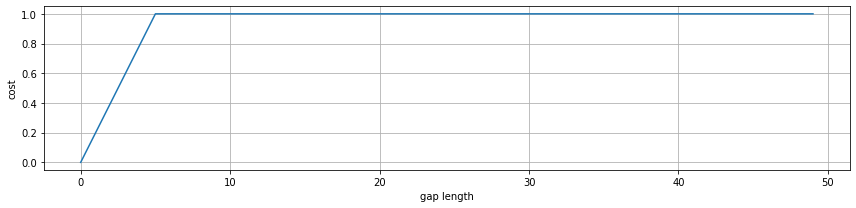

In [1]:
from vectorian.alignment import LinearGapCost, WatermanSmithBeyer

LinearGapCost(0.2)

In [3]:
#session.exponential_gap_costs(5)  # , 20)session.max_sentence_len

waterman_smith_beyer(gap=0.2, zero=0.5)

{'algorithm': 'wsb', 'gap': array([0.2], dtype=float32), 'zero': 0.5}

In [5]:
r = session.find(query, n=3, options={
    'alignment': WatermanSmithBeyer(gap=LinearGapCost(0.2), zero=0.5)
})

True

In [3]:
current_path

PosixPath('/Users/arbeit/Projects/vectorian-2021')

# Query Details Example

In [12]:
r[0].query.text

'play'

In [13]:
len(r[0].document.text)

6457

In [14]:
r[0].document.tokens

{'id': array([ 0,  1,  2, ...,  6,  6, -1], dtype=int32),
 'idx': array([   0,    2,    7, ..., 6568, 6570, 6571], dtype=int32),
 'len': array([1, 5, 4, ..., 2, 1, 0], dtype=int8),
 'pos': array([ 0,  1,  1, ...,  3,  3, -1], dtype=int8),
 'tag': array([ 0,  1,  1, ...,  3,  3, -1], dtype=int8)}

In [16]:
r[0].assignment

{'idx': array([66], dtype=int16),
 'sim': array([0.7944386], dtype=float32),
 'w': array([1.], dtype=float32)}

In [17]:
sent = r[0].document.sentence(r[0].sentence)
sent

{'book': -1,
 'chapter': -1,
 'speaker': -1,
 'paragraph': 8,
 'token_at': 110,
 'n_tokens': 101}

In [20]:
index = r[0].assignment["idx"][0] + sent["token_at"]
start = r[0].document.tokens["idx"][index]
end = start + r[0].document.tokens["len"][index]
print("match with: ", r[0].document.substr(start, end))
print("sim: ", r[0].assignment["sim"][0])

match with:  playing
sim:  0.7944386


In [13]:
doc

In [8]:
doc.save("/Users/arbeit/Desktop/doc.json")

In [12]:
print(doc.structure)

partition 1:
  sentence 1:
    A Child’s Dream Of A Star.
  sentence 2:
    


partition 2:
  sentence 1:
    


partition 3:
  sentence 1:
    


partition 4:
  sentence 1:
    A CHILD’S DREAM OF A STAR.
  sentence 2:
    


partition 5:
  sentence 1:
    
Short Stories Table of Contents.
  sentence 2:
    


partition 6:
  sentence 1:
    THERE was once a child, and he strolled about a good deal, and thought of a number of things.
  sentence 2:
    He had a sister, who was a child too, and his constant companion.
  sentence 3:
    These two used to wonder all day long.
  sentence 4:
    They wondered at the beauty of the flowers; they wondered at the height and blueness of the sky; they wondered at the depth of the bright water; they wondered at the goodness and the power of God, who made the lovely world.
  sentence 5:
    


partition 7:
  sentence 1:
    


partition 8:
  sentence 1:
    


partition 9:
  sentence 1:
    They used to say to one another, sometimes,
  sentence 2:
  

# Interactive GUI

In [11]:
query = nlp("large")
r = session.find(query, n=3, options={'tag_weights': {
    'JJ': 0.8
}})
r

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

# Sentence Embeddings

In [1]:
from pathlib import Path

import os
import sys

current_path = Path(os.getcwd())
sys.path.append(str(current_path))

import vectorian

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [3]:
from vectorian.metrics import SentenceEmbeddingMetric
metric = SentenceEmbeddingMetric(model.encode)

Matching checksum for /Users/arbeit/Projects/vectorian-2021/vectorian/core/cpp/core.cpp --> not compiling


In [4]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [5]:
from vectorian.importers import StringImporter
from vectorian.session import LabSession

im = StringImporter(nlp)
docs = [im(x) for x in [
    "Hey, ye want to talk like a pirate, eh?",
    "Summer strolls are beautiful."]]

session = LabSession(docs)
index = session.partition("sentence").index(metric)

Encoding: 100%|██████████| 2/2 [00:00<00:00, 15.72it/s]


In [6]:
#docs[0].to_json()

In [8]:
index.find("sea")

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [ ]:
from vectorian.importers import NovelImporter
from vectorian.session import LabSession

im = NovelImporter(nlp)
doc = im("/Users/arbeit/Wise Children.txt")
session = LabSession([doc])
index = session.partition("sentence", 2).index(metric)

In [10]:
doc.save("/Users/arbeit/Desktop/novel.json")

In [9]:
index.save(Path("/Users/arbeit/Desktop/my_index"))

Saving: 100%|██████████| 1/1 [00:00<00:00, 104.80it/s]


In [6]:
index = metric.load_index(session, "/Users/arbeit/Desktop/my_index")

FileNotFoundError: /Users/arbeit/Desktop/my_index/2021-03-03-10-45-05-346683.npy

In [14]:
session.documents[0].tokens['len'][386]

0

In [7]:
index.find("two and four")
#index.find("making America great again")
#index.find("under the greenwood tree")

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

returning text 29736 29753 Yes!Seventy-five.
returning text 1914 1941 Heroes and Villains

Love


returning text 117 146 Chapter Three

Chapter Four


returning text 91 117 Chapter One

Chapter Two


returning text 27587 27615 4–5.8 Shaking a Leg, p. 604.
returning text 57185 57222 Rivers of tears.Tempests of applause.
returning text 26932 26953 p. 37.2 Ibid., p. 40.
returning text 1596 1627 Fireworks

The Bloody Chamber


returning text 47262 47307 And Fred and Ginger, of course.Good old Fred.
returning text 13871 13893 But I got a lotin!’5




In [6]:
from vectorian.importers import ShakespeareImporter
from vectorian.session import LabSession

im = ShakespeareImporter(nlp)
doc = im("/Users/arbeit/Desktop/play.xml")
session = LabSession(
    [doc],
    static_embeddings=[fasttext],
    token_mappings=token_mappings)

Importing /Users/arbeit/Desktop/play.xml: 100%|██████████| 916/916 [00:07<00:00, 128.00it/s]


In [7]:
index = session.index_for_metric()

In [8]:
index.find(nlp("girl"))

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [14]:
doc._json["metadata"]

{'version': '1.0',
 'unique_id': 'William Shakespeare/All’s Well That Ends Well',
 'origin': PosixPath('/Users/arbeit/Desktop/play.xml'),
 'author': 'William Shakespeare',
 'title': 'All’s Well That Ends Well',
 'speakers': {1: 'Countess of Roussillon',
  2: 'Bertram, Count of Roussillon',
  3: 'Lafew',
  4: 'Helena',
  5: 'Parolles',
  6: 'Countess’s Page',
  7: 'King of France',
  8: 'First French Lord Dumaine',
  9: 'Second French Lord Dumaine',
  10: 'Rinaldo',
  11: 'Lavatch',
  12: 'Both French Lords',
  13: 'All French Lords',
  14: 'First French Lord',
  15: 'Second French Lord',
  16: 'Fourth French Lord',
  17: 'Duke of Florence',
  18: 'An Old Widow of Florence',
  19: 'Diana',
  20: 'Mariana',
  21: 'Both Mariana and Widow',
  22: 'First Soldier as Interpreter',
  23: 'Second Soldier',
  24: 'Messenger',
  25: 'Gentleman'}}